In [1]:
#1D Simulation with grid [1, N] so diffusion is along y only

%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#Load Model
base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [3]:
# Relax ATP maintenance reactions
# for m in [base1, base2]:
#     for rxn in m.reactions:
#         if rxn.id.upper().startswith("ATPM"):
#             rxn.lower_bound = 0.0

# Set default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0


#COMETS models
bifido_comets = c.model(base1)
Eubacterium_comets = c.model(base2)

bifido_comets.open_exchanges()
Eubacterium_comets.open_exchanges()


#bifido_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
#Eubacterium_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

# Clean non-EX exchanges (Comets fixed issue)
for m in [bifido_comets, Eubacterium_comets]:
    ex_mask = m.reactions["EXCH"].isin([True, "True"])
    exchanges_df = m.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0

In [4]:
#case I: species in the same cell (x=0, y=0).  glucose starts at (0,0) and diffuse along the 1D column , no refresh 

In [ ]:
# 1D column length 
GRID_X = 1
GRID_Y = 30
START_LOC = (0, 0)

# Mixed culture: Both species start in the same location
init_biomass_each = 0.01
bifido_comets.initial_pop = [[START_LOC[0], START_LOC[1], init_biomass_each]]
Eubacterium_comets.initial_pop = [[START_LOC[0], START_LOC[1], init_biomass_each]]

#middle of the grid
# init_biomass_each = 0.01
# bifido_comets.initial_pop = [[START_LOC[0], GRID_Y//2, init_biomass_each]]
# Eubacterium_comets.initial_pop = [[START_LOC[0], GRID_Y//2, init_biomass_each]]

ly = c.layout([bifido_comets, Eubacterium_comets])
ly.grid = [GRID_X, GRID_Y]

#ly.set_specific_metabolite("ser_L[e]", 1000.0)
#ly.set_specific_static("ser_L[e]", 1000.0)
ly.set_specific_metabolite("nh4[e]", 1000.0)
ly.set_specific_static("nh4[e]", 1000.0)

trace_metabolites = [
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]', 'leu_L[e]', 'hxan[e]', 'glyglu[e]',
]

for met in trace_metabolites:
    ly.set_specific_metabolite(met, 1000.0)
    ly.set_specific_static(met, 1000.0)


ly.set_specific_metabolite("glc_D[e]", 0.0)   # Zero glucose everywhere
ly.set_specific_refresh("glc_D[e]", 0.0)      #no replenishment

initial_glucose = 1  # I'm using small initial glucose to see depletion
ly.set_specific_metabolite_at_location("glc_D[e]", START_LOC, initial_glucose)
ly.set_specific_refresh_at_location("glc_D[e]", START_LOC, 0.0)

# Diffusion 
ly.set_metabolite_diffusion(1e-7)  #2e-8
ly.set_specific_metabolite_diffusion("glc_D[e]", 5e-8)  #1e-8

#media
Tmedia = trace_metabolites + ["glc_D[e]", "nh4[e]"]

#set uptake bounds
# def set_uptake_bounds(comets_model, mets, lb_val=-100.0):
#     for met in mets:
#         mask = comets_model.reactions["REACTION_NAMES"] == f"EX_{met}".replace("[", "(").replace("]", ")")
#         if mask.any():
#             comets_model.reactions.loc[mask, "LB"] = lb_val
#             print(f"Enabled {met} uptake for {comets_model.id}")

# set_uptake_bounds(bifido_comets, Tmedia, lb_val=-10.0)
# set_uptake_bounds(Eubacterium_comets, Tmedia, lb_val=-10.0)
# set_uptake_bounds(Eubacterium_comets, ["lac_L[e]"], lb_val=-10.0)
# set_uptake_bounds(bifido_comets, ["ser_Thr[e]"], lb_val=-10.0)

# Parameters
cycles = 200
t_step = 0.1

p = c.params()

p.all_params["maxCycles"] = cycles
p.all_params["timeStep"] = t_step
p.all_params["spaceWidth"] = 0.01
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = 1
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = 1
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = 1
p.all_params["biomassMotionStyle"] = "ConvNonlin Diffusion 2D"
p.all_params["maxSpaceBiomass"] = 1  #0.055
p.all_params["minSpaceBiomass"] = 1.0e-11
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0.8
p.all_params["defaultVmax"] = 10.0
p.all_params["defaultKm"] = 0.001
p.all_params["defaultHill"] = 1
p.all_params["exchangestyle"] = "Monod Style"

sim = c.comets(ly, p)
sim.run()

this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...
Done!


In [5]:
sim.total_biomass["Eubacterium"]

0      0.010000
1      0.010000
2      0.010539
3      0.011107
4      0.011706
         ...   
196    0.036609
197    0.036657
198    0.036703
199    0.036748
200    0.036791
Name: Eubacterium, Length: 201, dtype: float64

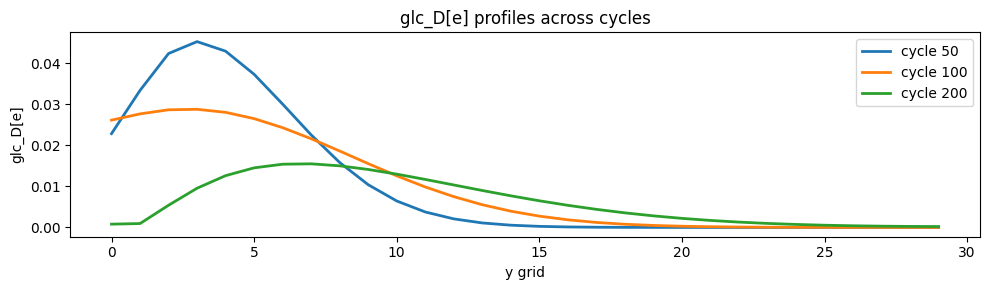

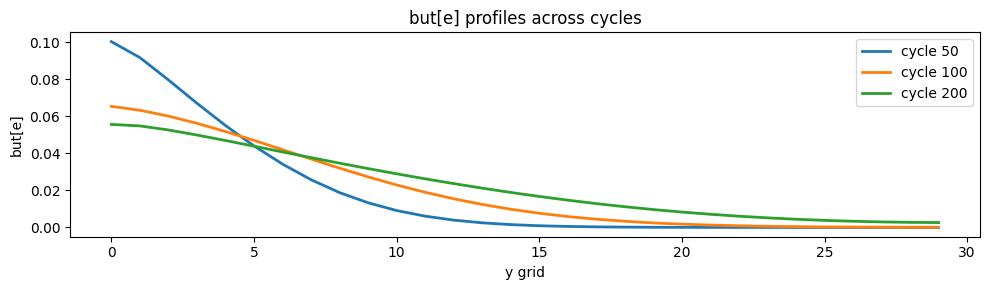

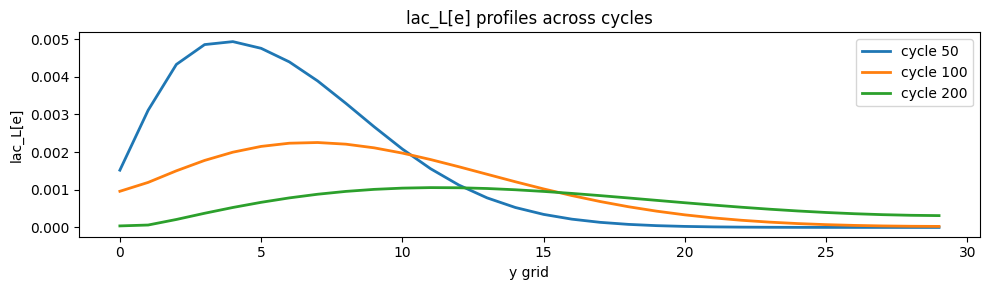

In [6]:
def plot_metabolite_profile(sim, grid_y, cycles, met="glc_D[e]"):
    
    'Plot one metabolite along the 1D grid for multiple cycles on the same graph'
    
    y = np.arange(grid_y)

    plt.figure(figsize=(10, 3))

    for cycle in cycles:
        im = sim.get_metabolite_image(met, cycle)

        # Convert returned 2D image to a 1D profile
        if im.shape[0] > 1:      # (GRID_Y, 1)
            v = im[:, 0]
        else:                    # (1, GRID_Y)
            v = im[0, :]

        plt.plot(y, v, linewidth=2, label=f"cycle {cycle}")

    plt.xlabel("y grid")
    plt.ylabel(met)
    plt.title(f"{met} profiles across cycles")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="glc_D[e]")
plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="but[e]")
plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="lac_L[e]")

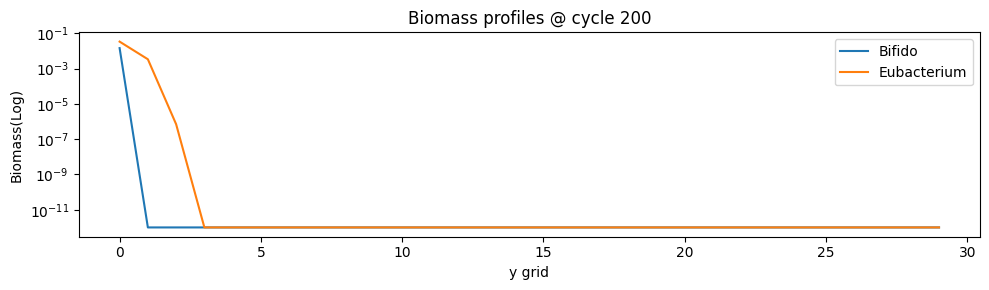

In [7]:
def plot_biomass_profiles(sim, grid_y, cycle, species=("Bifido", "Eubacterium")):
    "Plot one or more species' biomass profiles along the 1D grid."
    y = np.arange(grid_y)

    plt.figure(figsize=(10, 3))
    for sp in species:
        im = sim.get_biomass_image(sp, cycle)

    # this fixed another cometspy bug
        if im.shape[0] > 1:         # (GRID_Y, 1)
            im = np.roll(im, shift=1, axis=0)
            v = im[:, 0]
        else:                        # (1, GRID_Y)
            im = np.roll(im, shift=1, axis=1)
            v = im[0, :]

        v = np.maximum(v, 1e-12) # for log scale
        plt.plot(y, v, label=sp)
        
    plt.xlabel("y grid")
    plt.ylabel("Biomass(Log)")
    plt.title(f"Biomass profiles @ cycle {cycle}")
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.show()
    
plot_biomass_profiles(sim, GRID_Y, cycle=200, species=("Bifido","Eubacterium"))

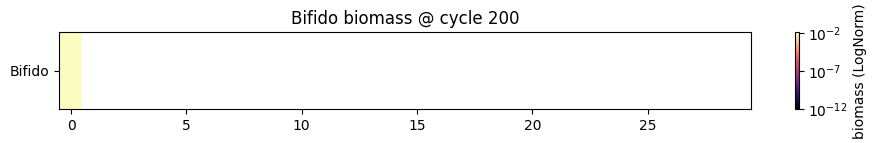

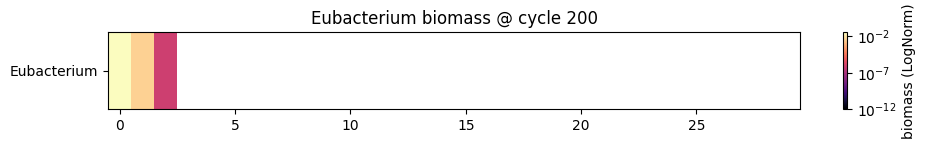

In [8]:
def show_biomass_image_lognorm(sim, species="Eubacterium", cycle=100, cmap="magma", vmin=1e-12):
    im = sim.get_biomass_image(species, cycle)

    # Fix cometspy bug
    if im.shape[0] > 1:      # (GRID_Y, 1)
        im = np.roll(im, shift=1, axis=0)
    else:                    # (1, GRID_Y)
        im = np.roll(im, shift=1, axis=1)

    vmax = max(float(np.max(im)), vmin)
    
    fig = plt.figure(figsize=(10, 1));fig.subplots_adjust(right=0.99)
    plt.imshow(im, aspect="auto", origin="lower", cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.colorbar(label="biomass (LogNorm)")
    plt.title(f"{species} biomass @ cycle {cycle}")
    plt.yticks([0], [species])
    plt.show()

show_biomass_image_lognorm(sim, species="Bifido", cycle=200)
show_biomass_image_lognorm(sim, species="Eubacterium", cycle=200)

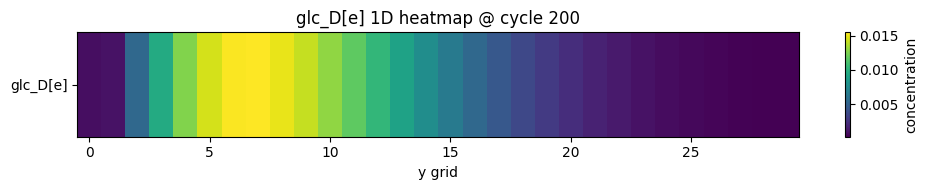

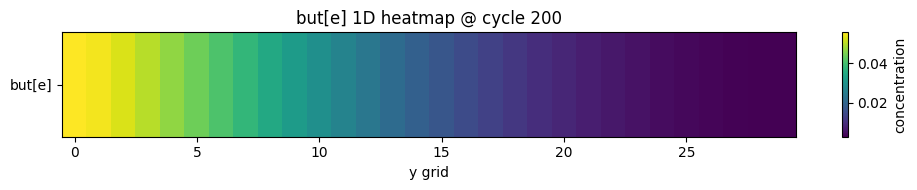

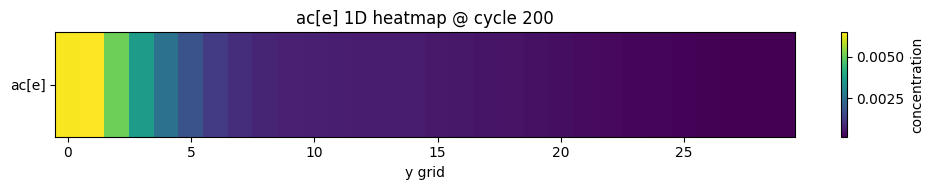

In [9]:
def metabolite_1d(sim, met="but[e]", cycle=100, cmap="viridis", figsize=(10, 2)):

    v = sim.get_metabolite_image(met, cycle)

    # Convert returned 2D image to a 1D profile
    if v.shape[0] > 1:   # (GRID_Y, 1)
        im1 = v[:, 0]
    else:                # (1, GRID_Y)
        im1 = v[0, :]

    plt.figure(figsize=figsize)
    plt.imshow(im1.reshape(1, -1), aspect="auto", cmap=cmap, interpolation="nearest")
    plt.yticks([0], [met])
    plt.xlabel("y grid")
    plt.colorbar(label="concentration")
    plt.title(f"{met} 1D heatmap @ cycle {cycle}")
    plt.tight_layout()
    plt.show()

metabolite_1d(sim, met="glc_D[e]", cycle=200)
metabolite_1d(sim, met="but[e]", cycle=200)
metabolite_1d(sim, met="ac[e]", cycle=200)

In [10]:

last_cycle = int(sim.media["cycle"].max())
print("last_cycle:", last_cycle)

def prof(met_or_species, kind="met"):
    if kind == "met":
        im = sim.get_metabolite_image(met_or_species, last_cycle)
    else:
        im = sim.get_biomass_image(met_or_species, last_cycle)
    arr = np.array(im)
    # for GRID_X=1, take the column
    return arr[:,0] if arr.shape[1] == 1 else arr[0,:]

glc = prof("glc_D[e]", "met")
nh4 = prof("nh4[e]", "met")
bif = prof("Bifido", "bio")
eub = prof("Eubacterium", "bio")

print("glc min/max:", float(glc.min()), float(glc.max()))
print("nh4 min/max:", float(nh4.min()), float(nh4.max()))
print("bif max:", float(bif.max()), "  (compare to maxSpaceBiomass =", p.all_params["maxSpaceBiomass"], ")")
print("eub max:", float(eub.max()), "  (compare to maxSpaceBiomass =", p.all_params["maxSpaceBiomass"], ")")

display(sim.total_biomass.tail(10))

last_cycle: 200
glc min/max: 0.00021592016449 0.015495500993
nh4 min/max: 1000.0 1000.0
bif max: 0.014346891875   (compare to maxSpaceBiomass = 1 )
eub max: 0.033436758831   (compare to maxSpaceBiomass = 1 )


,cycle,Bifido,Eubacterium
191,191,0.014342,0.036323
192,192,0.014343,0.036387
193,193,0.014344,0.036448
194,194,0.014344,0.036504
195,195,0.014345,0.036558
196,196,0.014345,0.036609
197,197,0.014346,0.036657
198,198,0.014346,0.036703
199,199,0.014347,0.036748
200,200,0.014347,0.036791


In [12]:
## Case II: where Bifido at top, Eubacterium at bottom initial

In [ ]:
%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

# Relax ATP maintenance reactions
for m in [base1, base2]:
    for rxn in m.reactions:
        if rxn.id.upper().startswith("ATPM"):
            rxn.lower_bound = 0.0

# Set default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

bifido_comets = c.model(base1)
Eubacterium_comets = c.model(base2)


# Clean non-EX exchanges
for m in [bifido_comets, Eubacterium_comets]:
    ex_mask = m.reactions["EXCH"].isin([True, "True"])
    exchanges_df = m.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


# 1D column length 
GRID_X = 1
GRID_Y = 30
START_LOC = (0, 0)

init_biomass_each = 0.01
# Bifido at top (y=0)
bifido_comets.initial_pop = [[0, 0, init_biomass_each]]
# Eubacterium at bottom (y=GRID_Y-1)
Eubacterium_comets.initial_pop = [[0, GRID_Y - 1, init_biomass_each]]

ly = c.layout([bifido_comets, Eubacterium_comets])
ly.grid = [GRID_X, GRID_Y]

#ly.set_specific_metabolite("ser_L[e]", 1000.0)
#ly.set_specific_static("ser_L[e]", 1000.0)
ly.set_specific_metabolite("nh4[e]", 1000.0)
ly.set_specific_static("nh4[e]", 1000.0)

trace_metabolites = [
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]', 'leu_L[e]', 'hxan[e]', 'glyglu[e]'
]

for met in trace_metabolites:
    ly.set_specific_metabolite(met, 1000.0)
    ly.set_specific_static(met, 1000.0)
    

ly.set_specific_metabolite("glc_D[e]", 0.0)
ly.set_specific_refresh("glc_D[e]", 0.0)
total_glc = 5.0
ly.set_specific_metabolite_at_location("glc_D[e]", (0, 0), total_glc/2)
ly.set_specific_metabolite_at_location("glc_D[e]", (0, GRID_Y-1), total_glc/2)


ly.set_metabolite_diffusion(1e-7)
ly.set_specific_metabolite_diffusion("glc_D[e]", 5e-7)
ly.set_specific_metabolite_diffusion("lac_L[e]", 5e-6)
ly.set_specific_metabolite_diffusion("but[e]", 1e-9)


Tmedia = trace_metabolites + ["glc_D[e]", "nh4[e]"]

def set_uptake_bounds(comets_model, mets, lb_val=-100.0):
    for met in mets:
        mask = comets_model.reactions["REACTION_NAMES"] == f"EX_{met}".replace("[", "(").replace("]", ")")
        if mask.any():
            comets_model.reactions.loc[mask, "LB"] = lb_val


set_uptake_bounds(bifido_comets, Tmedia, lb_val=-10.0)
set_uptake_bounds(Eubacterium_comets, Tmedia, lb_val=-10.0)
set_uptake_bounds(Eubacterium_comets, ["lac_L[e]"], lb_val=-10.0)
set_uptake_bounds(bifido_comets, ["ser_Thr[e]"], lb_val=-10.0)


cycles = 200
t_step = 0.1

p = c.params()

p.all_params["maxCycles"] = cycles
p.all_params["timeStep"] = t_step
p.all_params["spaceWidth"] = 0.01
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = 1
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = 1
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = 1
p.all_params["biomassMotionStyle"] = "ConvNonlin Diffusion 2D"
p.all_params["maxSpaceBiomass"] = 10  #0.055
p.all_params["minSpaceBiomass"] = 1.0e-11
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0.5

# Uptake kinetics
p.all_params["defaultVmax"] = 10.0
p.all_params["defaultKm"] = 1e-3
p.all_params["defaultHill"] = 1
p.all_params["exchangestyle"] = "Monod Style"

sim = c.comets(ly, p)
sim.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...
Done!


In [2]:
sim.total_biomass

,cycle,Bifido,Eubacterium
0,0,0.010000,0.010000
1,1,0.010000,0.010000
2,2,0.010134,0.010415
3,3,0.010269,0.010847
4,4,0.010406,0.011297
...,...,...,...
196,196,0.039429,0.147236
197,197,0.039455,0.147421
198,198,0.039480,0.147603
199,199,0.039505,0.147781


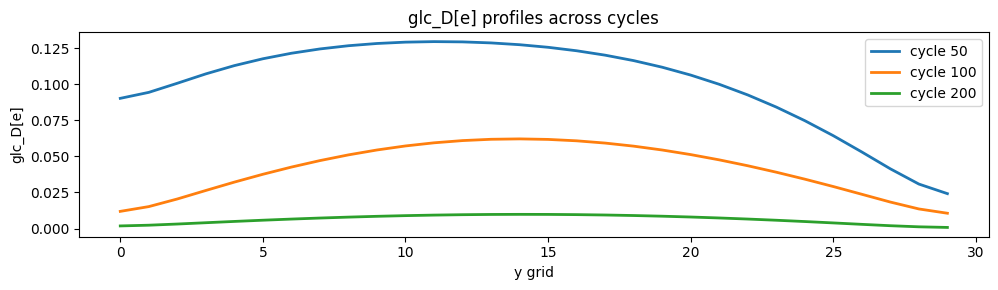

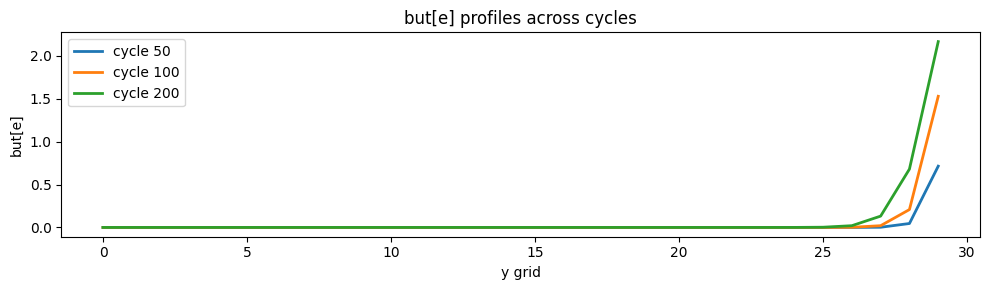

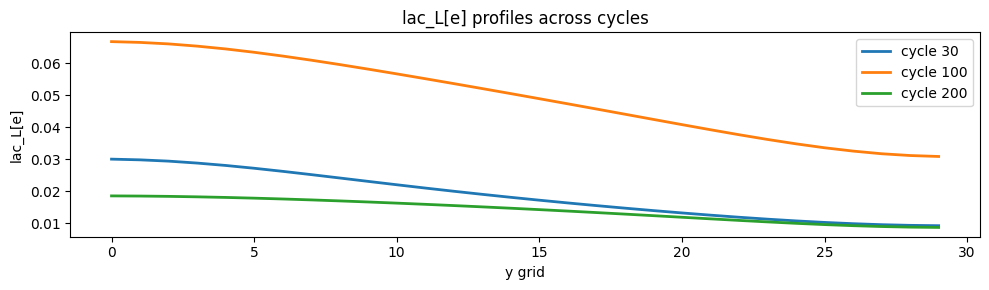

In [3]:
def plot_metabolite_profile(sim, grid_y, cycles, met="glc_D[e]"):
    """
    Plot one metabolite along the 1D grid for multiple cycles on the same graph
    """
    y = np.arange(grid_y)

    plt.figure(figsize=(10, 3))
    for cycle in cycles:
        im = sim.get_metabolite_image(met, cycle)

        if im.shape[0] > 1:      # (GRID_Y, 1)
            v = im[:, 0]
        else:                    # (1, GRID_Y)
            v = im[0, :]

        plt.plot(y, v, linewidth=2, label=f"cycle {cycle}")

    plt.xlabel("y grid")
    plt.ylabel(met)
    plt.title(f"{met} profiles across cycles")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="glc_D[e]")
plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="but[e]")
plot_metabolite_profile(sim, GRID_Y, [30,100, 200], met="lac_L[e]")

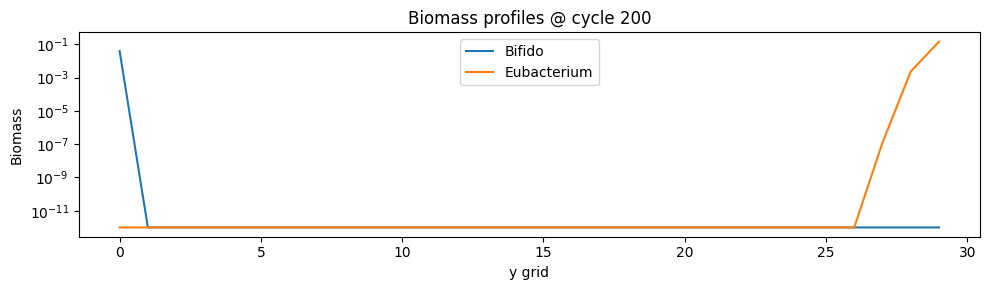

In [4]:

def plot_biomass_profiles(sim, grid_y, cycle, species=("Bifido", "Eubacterium")):
    "Plot one or more species' biomass profiles along the 1D grid"
    y = np.arange(grid_y)

    plt.figure(figsize=(10, 3))
    for sp in species:
        im = sim.get_biomass_image(sp, cycle)

        if im.shape[0] > 1:         # (GRID_Y, 1)
            im = np.roll(im, shift=1, axis=0)
            v = im[:, 0]
        else:                        # (1, GRID_Y)
            im = np.roll(im, shift=1, axis=1)
            v = im[0, :]

        v = np.maximum(v, 1e-12) # for log scale
        plt.plot(y, v, label=sp)
        

    plt.xlabel("y grid")
    plt.ylabel("Biomass")
    plt.title(f"Biomass profiles @ cycle {cycle}")
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

plot_biomass_profiles(sim, GRID_Y, cycle=200, species=("Bifido","Eubacterium"))

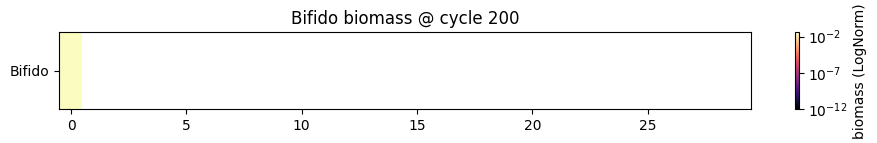

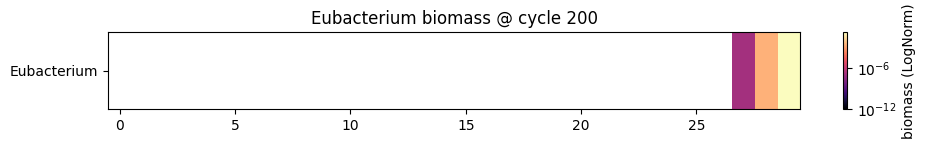

In [5]:
def show_biomass_image_lognorm(sim, species="Eubacterium", cycle=100, cmap="magma", vmin=1e-12):
    im = sim.get_biomass_image(species, cycle)

    # Fix cometspy bug
    if im.shape[0] > 1:      # (GRID_Y, 1)
        im = np.roll(im, shift=1, axis=0)
    else:                    # (1, GRID_Y)
        im = np.roll(im, shift=1, axis=1)

    vmax = max(float(np.max(im)), vmin)
    
    fig = plt.figure(figsize=(10, 1));fig.subplots_adjust(right=0.99)
    plt.imshow(im, aspect="auto", origin="lower", cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.colorbar(label="biomass (LogNorm)")
    plt.title(f"{species} biomass @ cycle {cycle}")
    plt.yticks([0], [species])
    plt.show()

show_biomass_image_lognorm(sim, species="Bifido", cycle=200)
show_biomass_image_lognorm(sim, species="Eubacterium", cycle=200)

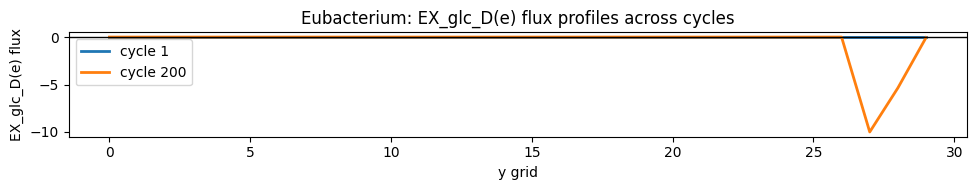

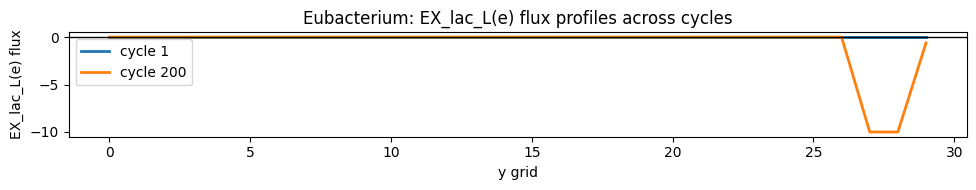

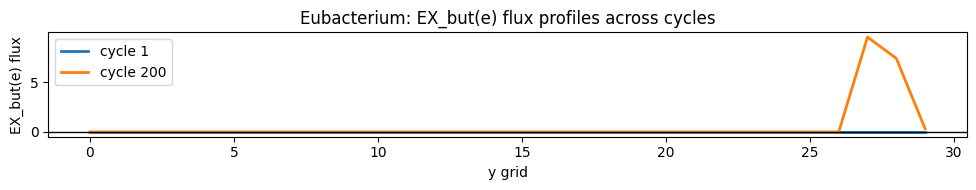

In [6]:
def plot_exchange_flux_profile(sim, grid_y, cycles, model_id, exchange_rxn_id, flip=False):

    y = np.arange(grid_y)

    plt.figure(figsize=(10, 2))
    for cycle in cycles:
        im = sim.get_flux_image(model_id, exchange_rxn_id, cycle)

        # Convert returned 2D image to a 1D profile
        if im.shape[0] > 1:      # (GRID_Y, 1)
            v = im[:, 0]
        else:                    # (1, GRID_Y)
            v = im[0, :]

        if flip:
            v = v[::-1]

        plt.plot(y, v, linewidth=2, label=f"cycle {cycle}")

    plt.axhline(0, color="k", linewidth=1)
    plt.xlabel("y grid")
    plt.ylabel(f"{exchange_rxn_id} flux")
    plt.title(f"{model_id}: {exchange_rxn_id} flux profiles across cycles")
    plt.legend()
    plt.tight_layout()
    plt.show()

cycles = [1,200]
plot_exchange_flux_profile(sim, GRID_Y, cycles, model_id="Eubacterium", exchange_rxn_id="EX_glc_D(e)")
plot_exchange_flux_profile(sim, GRID_Y, cycles, model_id="Eubacterium", exchange_rxn_id="EX_lac_L(e)")
plot_exchange_flux_profile(sim, GRID_Y, cycles, model_id="Eubacterium", exchange_rxn_id="EX_but(e)")

In [7]:
cycles = [5, 50, 100, 200]
y_bottom = GRID_Y  # media uses 1-based y indexing

for c in cycles:
    val = sim.media.loc[
        (sim.media["cycle"] == c) &
        (sim.media["metabolite"] == "lac_L[e]") &
        (sim.media["x"] == 1) &
        (sim.media["y"] == y_bottom),
        "conc_mmol"
    ].iloc[0]
    print(f"cycle {c}: lac_L[e] at bottom = {val}")

cycle 5: lac_L[e] at bottom = 0.00033118492994
cycle 50: lac_L[e] at bottom = 0.016593188518
cycle 100: lac_L[e] at bottom = 0.03084836446
cycle 200: lac_L[e] at bottom = 0.0087211862185


In [8]:
sim.media

,metabolite,cycle,x,y,conc_mmol
0,ala_L[e],0,1,2,1000.0
1,ala_L[e],0,1,3,1000.0
2,ala_L[e],0,1,4,1000.0
3,ala_L[e],0,1,5,1000.0
4,ala_L[e],0,1,6,1000.0
...,...,...,...,...,...
219873,zn2[e],200,1,26,1000.0
219874,zn2[e],200,1,27,1000.0
219875,zn2[e],200,1,28,1000.0
219876,zn2[e],200,1,29,1000.0


In [21]:
# Case III: Lets consider the case where Eubacterium at top, Bifido at bottom initial

In [1]:
%reset -f


import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

# Relax ATP maintenance reactions
for m in [base1, base2]:
    for rxn in m.reactions:
        if rxn.id.upper().startswith("ATPM"):
            rxn.lower_bound = 0.0

# Set default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

bifido_comets = c.model(base1)
Eubacterium_comets = c.model(base2)

# Clean non-EX exchanges
for m in [bifido_comets, Eubacterium_comets]:
    ex_mask = m.reactions["EXCH"].isin([True, "True"])
    exchanges_df = m.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


GRID_X = 1
GRID_Y = 30
START_LOC = (0, 0)


#  Eubacterium at top, Bifido at bottom initial
init_biomass_each = 0.01
# Eubacterium at top (y=0)
Eubacterium_comets.initial_pop = [[0, 0, init_biomass_each]]
# Bifido at bottom (y=GRID_Y-1)
bifido_comets.initial_pop = [[0, GRID_Y - 1, init_biomass_each]]

ly = c.layout([bifido_comets, Eubacterium_comets])
ly.grid = [GRID_X, GRID_Y]

#ly.set_specific_metabolite("ser_L[e]", 1000.0)
#ly.set_specific_static("ser_L[e]", 1000.0)
ly.set_specific_metabolite("nh4[e]", 1000.0)
ly.set_specific_static("nh4[e]", 1000.0)

trace_metabolites = [
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]', 'leu_L[e]', 'hxan[e]', 'glyglu[e]'
]

for met in trace_metabolites:
    ly.set_specific_metabolite(met, 1000.0)
    ly.set_specific_static(met, 1000.0)

ly.set_metabolite_diffusion(1e-7)
ly.set_specific_metabolite_diffusion("glc_D[e]", 5e-7)
#ly.set_specific_metabolite_diffusion("lac_L[e]", 5e-6)
ly.set_specific_metabolite_diffusion("lac_L[e]", 0.0)
ly.set_specific_metabolite_diffusion("but[e]", 1e-9)


ly.set_specific_metabolite("glc_D[e]", 0.0)
ly.set_specific_refresh("glc_D[e]", 0.0)
total_glc = 5.0
ly.set_specific_metabolite_at_location("glc_D[e]", (0, 0), total_glc/2)
ly.set_specific_metabolite_at_location("glc_D[e]", (0, GRID_Y-1), total_glc/2)


Tmedia = trace_metabolites + ["glc_D[e]", "nh4[e]"]

def set_uptake_bounds(comets_model, mets, lb_val=-100.0):
    for met in mets:
        mask = comets_model.reactions["REACTION_NAMES"] == f"EX_{met}".replace("[", "(").replace("]", ")")
        if mask.any():
            comets_model.reactions.loc[mask, "LB"] = lb_val

set_uptake_bounds(bifido_comets, Tmedia, lb_val=-10.0)
set_uptake_bounds(Eubacterium_comets, Tmedia, lb_val=-10.0)
set_uptake_bounds(Eubacterium_comets, ["lac_L[e]"], lb_val=-10.0)
#set_uptake_bounds(bifido_comets, ["ser_Thr[e]"], lb_val=-10.0)

cycles = 200
t_step = 0.1

p = c.params()
p.all_params["maxCycles"] = cycles
p.all_params["timeStep"] = t_step
p.all_params["spaceWidth"] = 0.01
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = 1
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = 1
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = 1
p.all_params["biomassMotionStyle"] = "ConvNonlin Diffusion 2D"
p.all_params["maxSpaceBiomass"] = 10  #0.055
p.all_params["minSpaceBiomass"] = 1.0e-11
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0.5
p.all_params["defaultVmax"] = 10.0
p.all_params["defaultKm"] = 1e-3
p.all_params["defaultHill"] = 1
p.all_params["exchangestyle"] = "Monod Style"

sim = c.comets(ly, p)
sim.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...
Done!


In [2]:
sim.total_biomass

,cycle,Bifido,Eubacterium
0,0,0.010000,0.010000
1,1,0.010000,0.010000
2,2,0.010134,0.010415
3,3,0.010269,0.010847
4,4,0.010406,0.011297
...,...,...,...
196,196,0.039478,0.116413
197,197,0.039504,0.116497
198,198,0.039530,0.116578
199,199,0.039555,0.116659


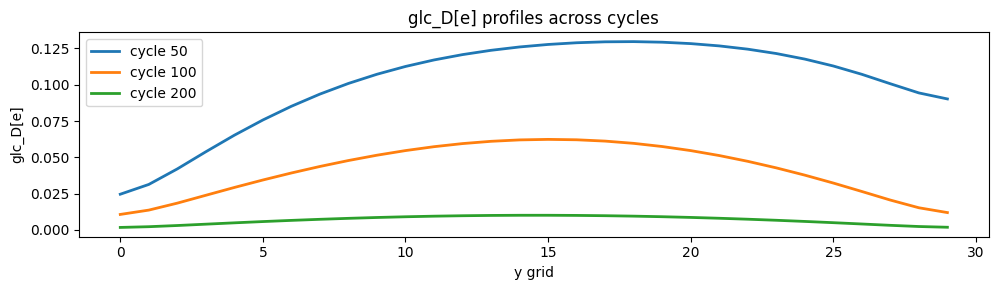

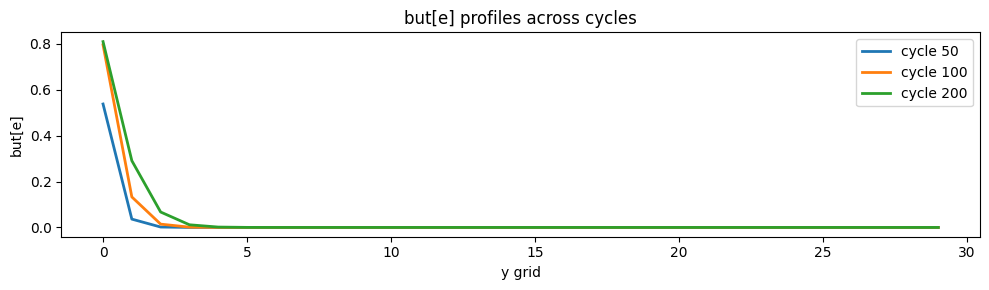

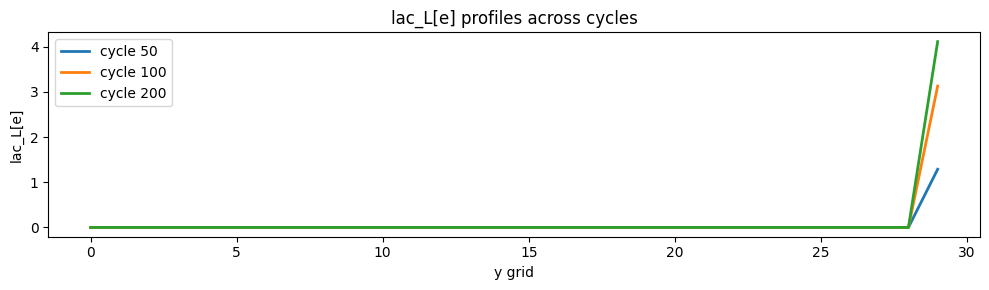

In [3]:
def plot_metabolite_profile(sim, grid_y, cycles, met="glc_D[e]"):
    
    "Plot one metabolite along the 1D grid for multiple cycles on the same graph"
    
    y = np.arange(grid_y)

    plt.figure(figsize=(10, 3))
    for cycle in cycles:
        im = sim.get_metabolite_image(met, cycle)

        # Convert returned 2D image to a 1D profile
        if im.shape[0] > 1:      # (GRID_Y, 1)
            v = im[:, 0]
        else:                    # (1, GRID_Y)
            v = im[0, :]

        plt.plot(y, v, linewidth=2, label=f"cycle {cycle}")

    plt.xlabel("y grid")
    plt.ylabel(met)
    plt.title(f"{met} profiles across cycles")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="glc_D[e]")
plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="but[e]")
plot_metabolite_profile(sim, GRID_Y, [50,100, 200], met="lac_L[e]")

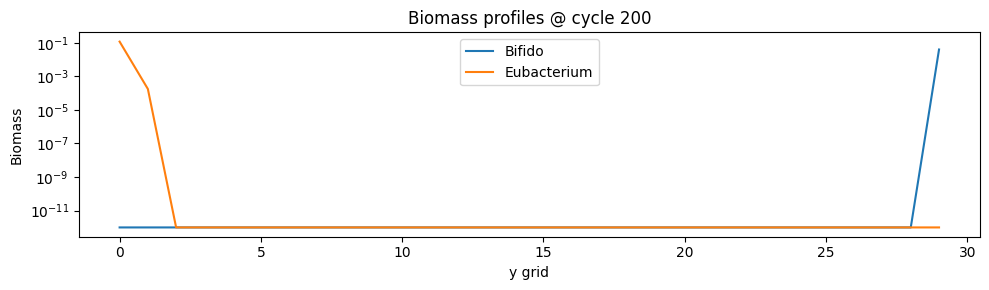

In [4]:

def plot_biomass_profiles(sim, grid_y, cycle, species=("Bifido", "Eubacterium")):
    "Plot one or more species' biomass profiles along the 1D grid"
    y = np.arange(grid_y)

    plt.figure(figsize=(10, 3))
    for sp in species:
        im = sim.get_biomass_image(sp, cycle)

        if im.shape[0] > 1:         # (GRID_Y, 1)
            im = np.roll(im, shift=1, axis=0)
            v = im[:, 0]
        else:                        # (1, GRID_Y)
            im = np.roll(im, shift=1, axis=1)
            v = im[0, :]

        v = np.maximum(v, 1e-12) # for log scale
        plt.plot(y, v, label=sp)
        

    plt.xlabel("y grid")
    plt.ylabel("Biomass")
    plt.title(f"Biomass profiles @ cycle {cycle}")
    plt.legend()
    plt.yscale("log")
    plt.tight_layout()
    plt.show()
    
plot_biomass_profiles(sim, GRID_Y, cycle=200, species=("Bifido","Eubacterium"))

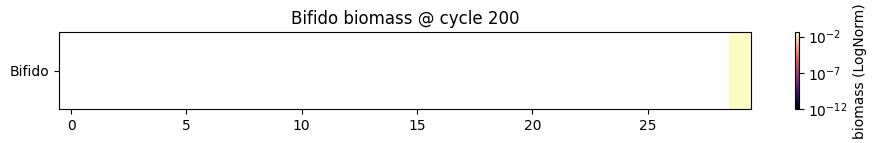

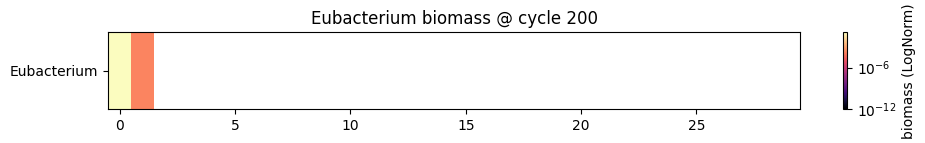

In [5]:
def show_biomass_image_lognorm(sim, species="Eubacterium", cycle=100, cmap="magma", vmin=1e-12):
    im = sim.get_biomass_image(species, cycle)

    # Fix cometspy bug
    if im.shape[0] > 1:      # (GRID_Y, 1)
        im = np.roll(im, shift=1, axis=0)
    else:                    # (1, GRID_Y)
        im = np.roll(im, shift=1, axis=1)

    vmax = max(float(np.max(im)), vmin)
    
    fig = plt.figure(figsize=(10, 1));fig.subplots_adjust(right=0.99)
    plt.imshow(im, aspect="auto", origin="lower", cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.colorbar(label="biomass (LogNorm)")
    plt.title(f"{species} biomass @ cycle {cycle}")
    plt.yticks([0], [species])
    plt.show()

show_biomass_image_lognorm(sim, species="Bifido", cycle=200)
show_biomass_image_lognorm(sim, species="Eubacterium", cycle=200)

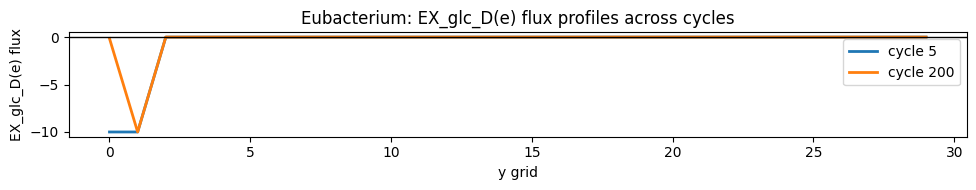

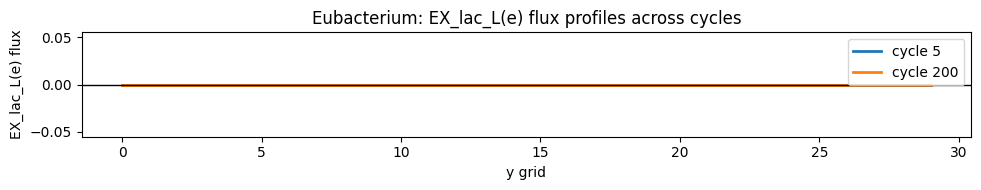

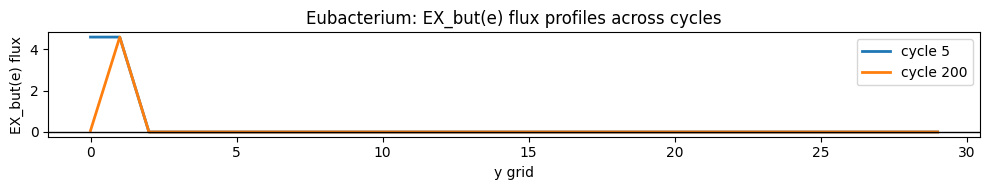

In [6]:
def plot_exchange_flux_profile(sim, grid_y, cycles, model_id, exchange_rxn_id, flip=False):

    y = np.arange(grid_y)

    plt.figure(figsize=(10, 2))
    for cycle in cycles:
        im = sim.get_flux_image(model_id, exchange_rxn_id, cycle)

        # Convert returned 2D image to a 1D profile
        if im.shape[0] > 1:      # (GRID_Y, 1)
            v = im[:, 0]
        else:                    # (1, GRID_Y)
            v = im[0, :]

        if flip:
            v = v[::-1]

        plt.plot(y, v, linewidth=2, label=f"cycle {cycle}")

    plt.axhline(0, color="k", linewidth=1)
    plt.xlabel("y grid")
    plt.ylabel(f"{exchange_rxn_id} flux")
    plt.title(f"{model_id}: {exchange_rxn_id} flux profiles across cycles")
    plt.legend()
    plt.tight_layout()
    plt.show()

cycles = [5,200]
plot_exchange_flux_profile(sim, GRID_Y, cycles, model_id="Eubacterium", exchange_rxn_id="EX_glc_D(e)")
plot_exchange_flux_profile(sim, GRID_Y, cycles, model_id="Eubacterium", exchange_rxn_id="EX_lac_L(e)")
plot_exchange_flux_profile(sim, GRID_Y, cycles, model_id="Eubacterium", exchange_rxn_id="EX_but(e)")

In [ ]:
## Another Simulation

In [1]:
%reset -f

import os
import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

In [2]:
def _clean_non_ex_exchanges(comets_model):
    ex_mask = comets_model.reactions["EXCH"].isin([True, "True"])
    exchanges_df = comets_model.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


def set_exchange_lb(comets_model, met_e, lb):
    ex_rxn = f"EX_{met_e}".replace("[", "(").replace("]", ")")
    mask = comets_model.reactions["REACTION_NAMES"] == ex_rxn
    if mask.any():
        comets_model.reactions.loc[mask, "LB"] = lb


def set_exchange_ub(comets_model, met_e, ub):
    ex_rxn = f"EX_{met_e}".replace("[", "(").replace("]", ")")
    mask = comets_model.reactions["REACTION_NAMES"] == ex_rxn
    if mask.any():
        comets_model.reactions.loc[mask, "UB"] = ub


def set_static_media(layout, met_list, conc=1000.0):
    for met in met_list:
        layout.set_specific_metabolite(met, conc)
        layout.set_specific_static(met, conc)


def end_conc_timeseries(sim, met, grid_y, at_end: str = "downstream"):
    "Return dataframe with concentration at upstream(y=1) or downstream(y=grid_y) using sim.media"

    y_val = 1 if at_end == "upstream" else grid_y
    df = sim.media
    out = df[(df["metabolite"] == met) & (df["x"] == 1) & (df["y"] == y_val)][["cycle", "conc_mmol"]].copy()
    out = out.sort_values("cycle")
    out.rename(columns={"conc_mmol": f"{met}:{at_end}"}, inplace=True)
    return out



In [3]:
TRACE_METS = [
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]', 'leu_L[e]', 'hxan[e]',
]

CORE_METS = ['ser_L[e]', 'nh4[e]']

# Key cross-feeding metabolites
GLC = 'glc_D[e]'
LAC = 'lac_L[e]'
BUT = 'but[e]'



def build_models(
    bifido_mat='Bifidobacterium_longum_infantis_ATCC_15697.mat',
    eub_mat='Eubacterium_hallii_DSM_3353.mat',
    relax_atpm=True,):

    base1 = cb.io.load_matlab_model(bifido_mat)
    base1.id = 'Bifido'
    base2 = cb.io.load_matlab_model(eub_mat)
    base2.id = 'Eubacterium'

    # if relax_atpm:
    #     for m in [base1, base2]:
    #         for rxn in m.reactions:
    #             if rxn.id.upper().startswith('ATPM'):
    #                 rxn.lower_bound = 0.0

    # Set default bounds for all exchanges
    for m in [base1, base2]:
        for rxn in m.exchanges:
            rxn.lower_bound = 0.0
            rxn.upper_bound = 1000.0

    bif = c.model(base1)
    eub = c.model(base2)

    # Keep objective style stable
    #bif.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL'
    #eub.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL'

    # Open exchanges 
    bif.open_exchanges()
    eub.open_exchanges()

    _clean_non_ex_exchanges(bif)
    _clean_non_ex_exchanges(eub)

    return bif, eub


def run_1d_crossfeed(
    grid_y=30,
    init_biomass=0.01,
    glc_refresh_upstream=0.05,
    cycles=300,
    t_step=0.1,
    space_width=0.01,
    # Diffusion 
    D_base=1e-7,
    D_glc=5e-8,
    D_lac=5e-7,
    D_but=1e-9,

    # Exchange preference 
    eub_glc_lb=-0.05,   # allow but strongly limit glucose uptake
    eub_lac_lb=-10.0,   # strong lactate uptake
    bif_glc_lb=-10.0,   # allow glucose uptake
):
    GRID_X = 1
    GRID_Y = int(grid_y)

    # Build fresh models each run
    bif, eub = build_models()

    # Seed at opposite ends
    bif.initial_pop = [[0, 0, float(init_biomass)]]
    eub.initial_pop = [[0, GRID_Y - 1, float(init_biomass)]]

    ly = c.layout([bif, eub])
    ly.grid = [GRID_X, GRID_Y]

    # Static background nutrients 
    set_static_media(ly, TRACE_METS, conc=1000.0)
    set_static_media(ly, CORE_METS, conc=10.0)

    # Glucose: 0 everywhere, with a boundary refresh at top cell
    ly.set_specific_metabolite(GLC, 0.0)
    ly.set_specific_refresh(GLC, 0.0)
    ly.set_specific_metabolite_at_location(GLC, (0, 0), 0.0)
    ly.set_specific_refresh_at_location(GLC, (0, 0), float(glc_refresh_upstream))

    # cross-feeding metabolites in the layout
    ly.set_specific_metabolite(LAC, 0.0)
    ly.set_specific_metabolite(BUT, 0.0)

    # Diffusion
    ly.set_metabolite_diffusion(D_base)
    ly.set_specific_metabolite_diffusion(GLC, D_glc)
    ly.set_specific_metabolite_diffusion(LAC, D_lac)
    ly.set_specific_metabolite_diffusion(BUT, D_but)

    # # --- Exchange constraints (core of the experimental question) ---
    # # Close everything by default (LB=0) then open only what you want
    # for m in [bif, eub]:
    #     # Only apply to exchange reactions
    #     ex_mask = m.reactions["EXCH"].isin([True, "True"])
    #     m.reactions.loc[ex_mask, "LB"] = 0.0
    #     m.reactions.loc[ex_mask, "UB"] = 1000.0

    # Bifido: consume glucose strongly
    set_exchange_lb(bif, GLC, bif_glc_lb)

    # Eubacterium: prefer lactate by limiting glucose 
    set_exchange_lb(eub, GLC, eub_glc_lb)
    set_exchange_lb(eub, LAC, eub_lac_lb)

    # allow core nutrients uptake 
    for met in TRACE_METS + CORE_METS:
        set_exchange_lb(bif, met, -10.0)
        set_exchange_lb(eub, met, -10.0)


    p = c.params()
    p.all_params["maxCycles"] = cycles
    p.all_params["timeStep"] = t_step
    p.all_params["spaceWidth"] = space_width

    p.all_params["writeBiomassLog"] = True
    p.all_params["BiomassLogRate"] = 1
    p.all_params["writeMediaLog"] = True
    p.all_params["MediaLogRate"] = 1
    p.all_params["writeFluxLog"] = True
    p.all_params["FluxLogRate"] = 1

    p.all_params["biomassMotionStyle"] = "ConvNonlin Diffusion 2D"
    p.all_params["growthDiffRate"] = 0.05

    p.all_params["maxSpaceBiomass"] = 10
    p.all_params["minSpaceBiomass"] = 1.0e-11
    p.all_params["allowCellOverlap"] = True
    p.all_params["exchangestyle"] = "Monod Style"
    p.all_params["defaultVmax"] = 10.0
    p.all_params["defaultKm"] = 1e-3

    sim = c.comets(ly, p)
    sim.run()

    return sim



No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e



Running GRID_Y=10 (physical length ~ 0.100) ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Done!

Running GRID_Y=20 (physical length ~ 0.200) ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Done!

Running GRID_Y=30 (physical length ~ 0.300) ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Done!

Running GRID_Y=50 (physical length ~ 0.500) ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Done!

Running GRID_Y=80 (physical length ~ 0.800) ...


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


this should be performed prior to setting specific metabolite diffusion

Running COMETS simulation ...
Done!


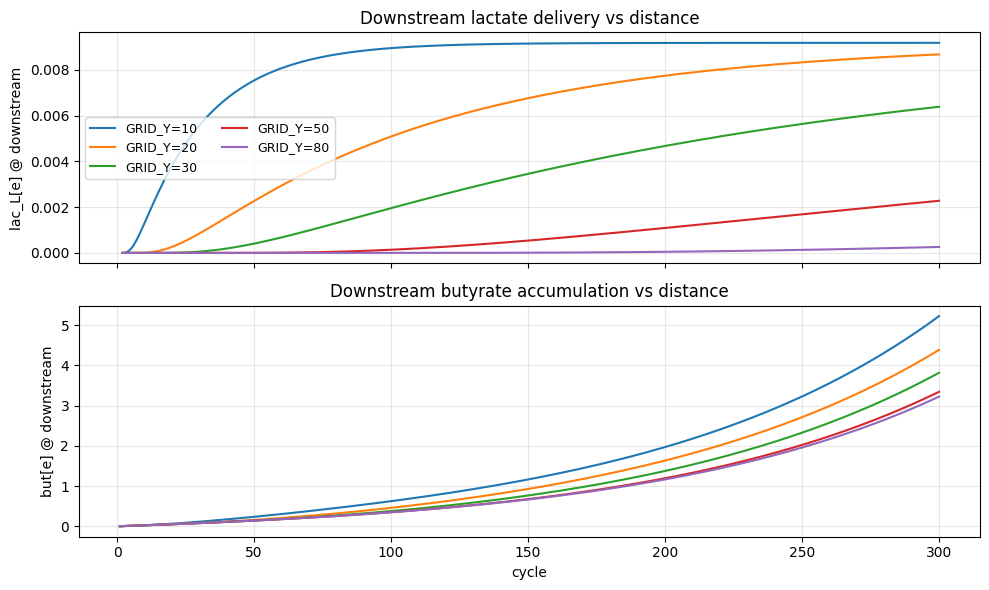

,GRID_Y,length,cycle,lac_L[e]:downstream,but[e]:downstream
299,10,0.1,300,0.009176,5.222033
599,20,0.2,300,0.008671,4.384100
899,30,0.3,300,0.006383,3.815689
1199,50,0.5,300,0.002277,3.341919
1499,80,0.8,300,0.000261,3.222042


In [4]:
GRID_Y_LIST = [10, 20, 30, 50, 80]   # vary distance between Bifido and Eubacterium
#GRID_Y_LIST = [10, 20, 30] 

CYCLES = 300
T_STEP = 0.1
SPACE_WIDTH = 0.01
GLC_REFRESH = 0.05

sims = {}

downstream_traces = []

for gy in GRID_Y_LIST:
    print(f"\nRunning GRID_Y={gy} (physical length ~ {gy*SPACE_WIDTH:.3f}) ...")

    sim = run_1d_crossfeed(
        grid_y=gy,
        cycles=CYCLES,
        t_step=T_STEP,
        space_width=SPACE_WIDTH,
        glc_refresh_upstream=GLC_REFRESH,
        # preference:
        eub_glc_lb=-0.05,
        eub_lac_lb=-10.0,
        bif_glc_lb=-10.0,
    )

    sims[gy] = sim

    # Downstream end concentrations (at the Eubacterium end)
    lac_end = end_conc_timeseries(sim, LAC, grid_y=gy, at_end='downstream')
    but_end = end_conc_timeseries(sim, BUT, grid_y=gy, at_end='downstream')

    merged = lac_end.merge(but_end, on='cycle', how='outer')
    merged['GRID_Y'] = gy
    merged['length'] = gy * SPACE_WIDTH
    downstream_traces.append(merged)


downstream = pd.concat(downstream_traces, ignore_index=True)


# Plot lactate & butyrate at downstream end vs time for each distance
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

for gy in GRID_Y_LIST:
    df = downstream[downstream['GRID_Y'] == gy].sort_values('cycle')
    axes[0].plot(df['cycle'], df[f'{LAC}:downstream'], label=f'GRID_Y={gy}')
    axes[1].plot(df['cycle'], df[f'{BUT}:downstream'], label=f'GRID_Y={gy}')

axes[0].set_ylabel(f'{LAC} @ downstream')
axes[1].set_ylabel(f'{BUT} @ downstream')
axes[1].set_xlabel('cycle')
axes[0].set_title('Downstream lactate delivery vs distance')
axes[1].set_title('Downstream butyrate accumulation vs distance')
axes[0].legend(ncol=2, fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Simple summary
summary = (
    downstream
    .dropna(subset=[f'{BUT}:downstream'])
    .sort_values('cycle')
    .groupby('GRID_Y')
    .tail(1)[['GRID_Y', 'length', 'cycle', f'{LAC}:downstream', f'{BUT}:downstream']]
    .sort_values('GRID_Y')
)
summary


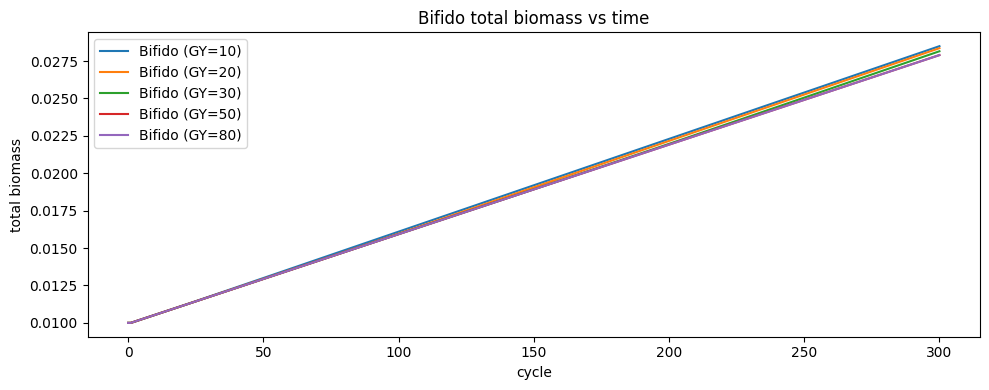

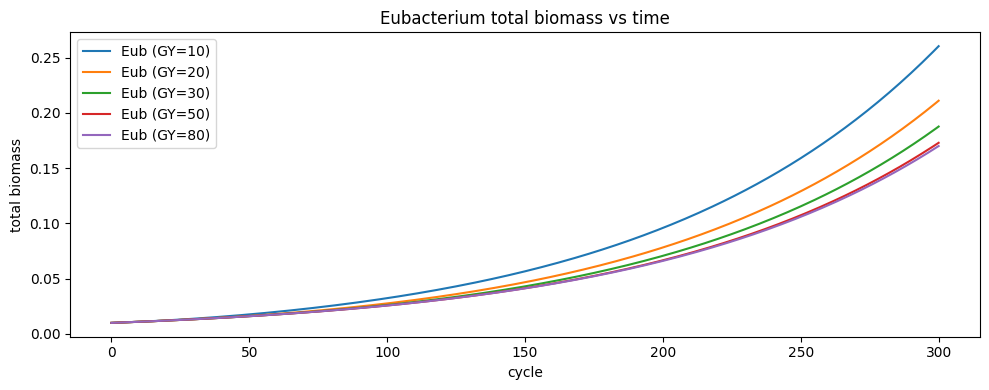

In [5]:
# Total biomass time series for each distance
plt.figure(figsize=(10, 4))
for gy, sim in sims.items():
    df = sim.total_biomass.copy()
    plt.plot(df["cycle"], df["Bifido"], label=f"Bifido (GY={gy})")
plt.xlabel("cycle"); plt.ylabel("total biomass"); plt.title("Bifido total biomass vs time"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 4))
for gy, sim in sims.items():
    df = sim.total_biomass.copy()
    plt.plot(df["cycle"], df["Eubacterium"], label=f"Eub (GY={gy})")
plt.xlabel("cycle"); plt.ylabel("total biomass"); plt.title("Eubacterium total biomass vs time"); plt.legend()
plt.tight_layout(); plt.show()

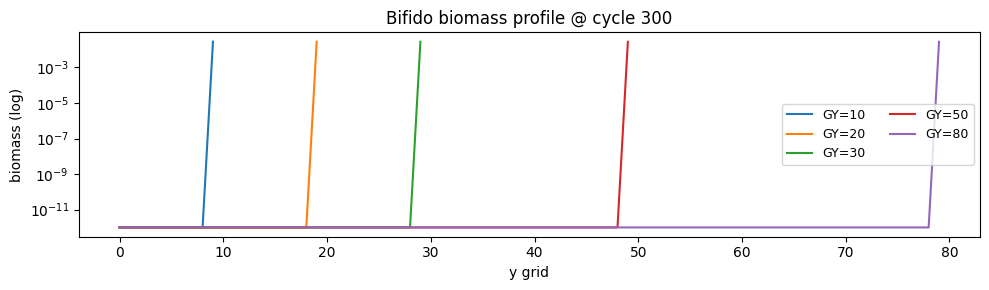

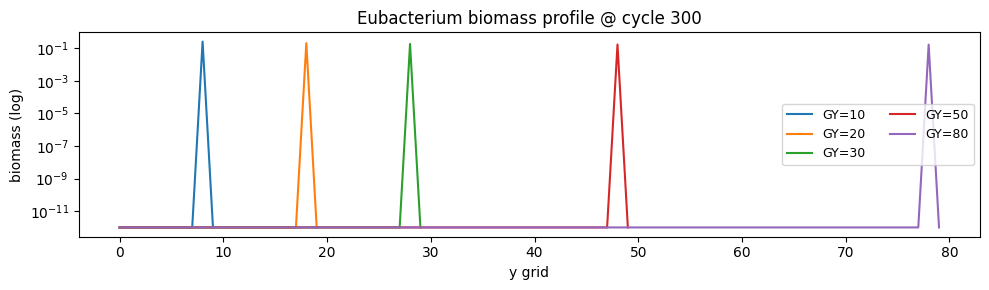

In [6]:
def biomass_profile_1d(sim, species, cycle, grid_y):
    im = sim.get_biomass_image(species, cycle)
    arr = np.array(im)
    # 1xN vs Nx1 handling
    prof = arr[:, 0] if arr.shape[1] == 1 else arr[0, :]
    # keep length consistent
    return prof[:grid_y]

cycle_to_plot = 300

plt.figure(figsize=(10, 3))
for gy, sim in sims.items():
    prof = biomass_profile_1d(sim, "Bifido", cycle_to_plot, gy)
    plt.plot(np.arange(gy), np.maximum(prof, 1e-12), label=f"GY={gy}")
plt.yscale("log")
plt.xlabel("y grid"); plt.ylabel("biomass (log)"); plt.title(f"Bifido biomass profile @ cycle {cycle_to_plot}")
plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 3))
for gy, sim in sims.items():
    prof = biomass_profile_1d(sim, "Eubacterium", cycle_to_plot, gy)
    plt.plot(np.arange(gy), np.maximum(prof, 1e-12), label=f"GY={gy}")
plt.yscale("log")
plt.xlabel("y grid"); plt.ylabel("biomass (log)"); plt.title(f"Eubacterium biomass profile @ cycle {cycle_to_plot}")
plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()